In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import cv2

In [ ]:
# Set some parameters
IMG_WIDTH = 176
IMG_HEIGHT = 176
IMG_CHANNELS = 3

TRAIN_PATH = '/content/drive/My Drive/U-Net2-1/data/train/' #enter path to training data
TEST_PATH = '/content/drive/My Drive/U-Net2-1/data/test/' #enter path to testing data

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

print("Imported all the dependencies")

# Get train and test IDs 
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
print(train_ids)
print(len(train_ids))

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = cv2.imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

Imported all the dependencies
['14cineSax', '17cineSax', '10cineSax', '15cineSax', '12cineSax', '13cineSax', '18cineSax', '16cineSax', '26cineSax', '23cineSax', '24cineSax', '21cineSax', '20cineSax', '29cineSax', '19cineSax', '22cineSax', '25cineSax', '27cineSax', '43cineSax', '32cineSax', '40cineSax', '30cineSax', '2cineSax', '42cineSax', '33cineSax', '36cineSax', '37cineSax', '31cineSax', '45cineSax', '59cineSax', '44cineSax', '50cineSax', '56cineSax', '5cineSax', '57cineSax', '53cineSax', '48cineSax', '54cineSax', '9cineSax', '7cineSax', '60cineSax', '8cineSax']
42
X_train (42, 176, 176, 3)
Y_train (42, 176, 176, 1)
Getting and resizing train images and masks ... 


  0%|          | 0/42 [00:00<?, ?it/s]


TypeError: ignored

In [ ]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 128, 128, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 128, 128, 16) 448         lambda_10[0][0]                  
__________________________________________________________________________________________________
dropout_82 (Dropout)            (None, 128, 128, 16) 0           conv2d_172[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 29 samples, validate on 4 samples
Epoch 1/30
29/29 [==============================] - 0s 3ms/step - loss: 0.4741 - acc: 0.8081 - val_loss: 0.5356 - val_acc: 0.7536

Epoch 00001: val_loss improved from inf to 0.53561, saving model to model-dsbowl2018-1.h5
Epoch 2/30
29/29 [==============================] - 0s 3ms/step - loss: 0.4636 - acc: 0.8019 - val_loss: 0.5531 - val_acc: 0.7489

Epoch 00002: val_loss did not improve from 0.53561
Epoch 3/30
29/29 [==============================] - 0s 2ms/step - loss: 0.4375 - acc: 0.8128 - val_loss: 0.5334 - val_acc: 0.7490

Epoch 00003: val_loss improved from 0.53561 to 0.53337, saving model to model-dsbowl2018-1.h5
Epoch 4/30
29/29 [==============================] - 0s 3ms/step - loss: 0.4069 - acc: 0.8149 - val_loss: 0.4292 - val_acc: 0.7812

Epoch 00004: val_loss improved from 0.53337 to 0.42923, saving model to model-dsbowl2018-1.h5
Epoch 5/30
29/29 [==============================] - 0s 2ms/step - loss: 0.3829 - acc: 0.8589 - val_loss:

model-dsbowl2018-1.h5
./test_image3.png
128
128
3
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 128, 128, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 128, 128, 16) 448         lambda_12[0][0]                  
__________________________________________________________________________________________________
dropout_100 (Dropout)           (None, 128, 128, 16) 0           conv2d_210[0][0]                 
_________________________________________

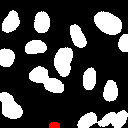

77 110 51 18


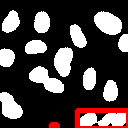

0 92 23 27


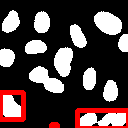

103 80 15 22


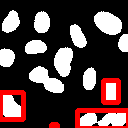

83 67 13 23


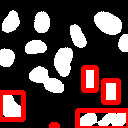

29 66 35 27


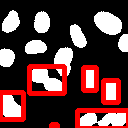

0 48 15 19


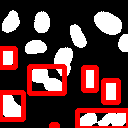

54 47 19 30


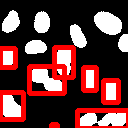

25 40 22 14


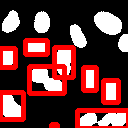

118 34 10 18


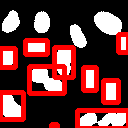

70 24 17 24


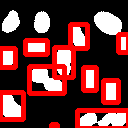

94 11 28 24


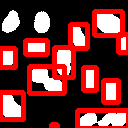

34 11 16 22


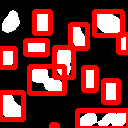

2 10 18 23


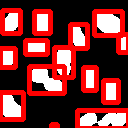

Showing images..


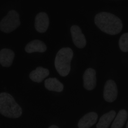

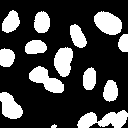

In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow

class automaticmaplabelling():
    def __init__(self,modelPath,full_chq,imagePath,width,height,channels):
        print (modelPath)
        print(imagePath)
        print(width)
        print(height)
        print(channels)
        self.modelPath=modelPath
        self.full_chq=full_chq
        self.imagePath=imagePath
        self.IMG_WIDTH=width
        self.IMG_HEIGHT=height
        self.IMG_CHANNELS=channels
        self.model = self.U_net()
        
    def mean_iou(self,y_true, y_pred):
        prec = []
        for t in np.arange(0.5, 1.0, 0.05):
            y_pred_ = tf.to_int32(y_pred > t)
            score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
            K.get_session().run(tf.local_variables_initializer())
            with tf.control_dependencies([up_opt]):
                score = tf.identity(score)
            prec.append(score)
        return K.mean(K.stack(prec), axis=0)

    def U_net(self):
        # Build U-Net model
        inputs = Input((self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS))
        s = Lambda(lambda x: x / 255) (inputs)

        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
        c1 = Dropout(0.1) (c1)
        c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
        p1 = MaxPooling2D((2, 2)) (c1)

        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
        c2 = Dropout(0.1) (c2)
        c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
        p2 = MaxPooling2D((2, 2)) (c2)

        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
        c3 = Dropout(0.2) (c3)
        c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
        p3 = MaxPooling2D((2, 2)) (c3)

        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
        c4 = Dropout(0.2) (c4)
        c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
        p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
        c5 = Dropout(0.3) (c5)
        c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

        u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
        u6 = concatenate([u6, c4])
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
        c6 = Dropout(0.2) (c6)
        c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

        u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
        u7 = concatenate([u7, c3])
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
        c7 = Dropout(0.2) (c7)
        c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

        u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
        u8 = concatenate([u8, c2])
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
        c8 = Dropout(0.1) (c8)
        c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

        u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
        u9 = concatenate([u9, c1], axis=3)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
        c9 = Dropout(0.1) (c9)
        c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

        outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

        model = Model(inputs=[inputs], outputs=[outputs])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[self.mean_iou])
        model.load_weights(self.modelPath)
        model.summary()
        return model

    def prediction(self):
        img=cv2.imread(self.imagePath,0)
        img=np.expand_dims(img,axis=-1)
        x_test= np.zeros((1, self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), dtype=np.uint8)
        #testimg=resize(img,(self.IMG_HEIGHT,self.IMG_WIDTH),mode='constant',preserve_range=True)
        x_test[0]=img
        preds_test= self.model.predict(x_test, verbose=1)
        
        preds_test = (preds_test > 0.5).astype(np.uint8)
        mask=preds_test[0]
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i][j] == 1:
                    mask[i][j] = 255
                else:
                    mask[i][j] = 0
        merged_image = cv2.merge((mask,mask,mask))
        contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        for each_contour in contours:
            x,y,w,h = cv2.boundingRect(each_contour)

            cv2.rectangle(merged_image,(x,y),(x+w,y+h),(0,0,255),4)

            print (x,y,w,h)
            cv2_imshow(merged_image)
            cv2.waitKey(0)
        
        cv2.imwrite("mask.png",mask)

        return x_test[0],mask

def main():
    test_image_name = "./test_image3.png"
    automaticmaplabellingobj= automaticmaplabelling('model-dsbowl2018-1.h5',True,test_image_name,128,128,3)
    testimg,mask = automaticmaplabellingobj.prediction()
    print('Showing images..')
    cv2_imshow(testimg)
    dim = (1280, 1280)
    resized = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
    
    cv2_imshow(mask)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite("resized_mask.png",resized)

if __name__ == "__main__":
    main()